# Fine-Tuning Training

This notebook fine-tunes EmbeddingGemma using LoRA and contrastive learning on semantic similarity pairs. We'll train the model to bring similar sentences closer together in embedding space.


In [1]:
# Import all necessary functions from the scripts directory
from src.data.loaders import load_toy_dataset
from src.models.embedding_pipeline import load_embeddinggemma_model
from src.models.lora_setup import setup_lora_model, print_trainable_parameters
from src.training.trainer import train_model
from src.utils.paths import timestamped_path
import torch


/home/goble54/spark-dev-workspace/Lora-for-embedding-models/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

We'll use the toy dataset for demonstration. In production, you would use a larger dataset like MS MARCO.


In [2]:
# Load the training dataset
train_data = load_toy_dataset()

print(f"Loaded {len(train_data)} training pairs")
print("\nFirst pair:")
print(f"  Anchor:   '{train_data[0]['anchor']}'")
print(f"  Positive: '{train_data[0]['positive']}'")


Loaded 4 training pairs

First pair:
  Anchor:   'I love playing football.'
  Positive: 'Playing soccer is my favorite hobby.'


## Load Model and Apply LoRA

We'll load the base EmbeddingGemma model and configure it with LoRA adapters for efficient fine-tuning.


In [3]:
# Load base model
tokenizer, base_model = load_embeddinggemma_model()

# Apply LoRA configuration
model = setup_lora_model(
    base_model,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj"]
)

# Verify only LoRA parameters are trainable
print_trainable_parameters(model)


/home/goble54/spark-dev-workspace/Lora-for-embedding-models/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


Trainable params: 1,376,256 (0.45% of 304,239,360)


{'trainable': 1376256, 'total': 304239360, 'percentage': 0.452359615797246}

## Training Configuration

Set hyperparameters for training:


In [4]:
# Training hyperparameters
EPOCHS = 10
BATCH_SIZE = 4  # Equal to dataset size for maximum in-batch negatives
LEARNING_RATE = 2e-4
TEMPERATURE = 1.0  # Loss temperature (can experiment with values like 0.05-1.0)

print(f"Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Temperature: {TEMPERATURE}")


Training Configuration:
  Epochs: 10
  Batch size: 4
  Learning rate: 0.0002
  Temperature: 1.0


## Train the Model

The training loop uses Multiple Negatives Ranking Loss, which encourages each anchor to be most similar to its own positive and less similar to other positives in the batch.


In [5]:
# Train the model
device = next(model.parameters()).device
losses = train_model(
    model=model,
    tokenizer=tokenizer,
    train_data=train_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    temperature=TEMPERATURE,
    device=device
)


Epoch 1/10: training loss = 1.2098
Epoch 2/10: training loss = 1.1712
Epoch 3/10: training loss = 1.1308
Epoch 4/10: training loss = 1.0902
Epoch 5/10: training loss = 1.0498
Epoch 6/10: training loss = 1.0097
Epoch 7/10: training loss = 0.9704
Epoch 8/10: training loss = 0.9336
Epoch 9/10: training loss = 0.8987
Epoch 10/10: training loss = 0.8660


## Plot Training Loss

Visualize how the loss decreases over epochs.


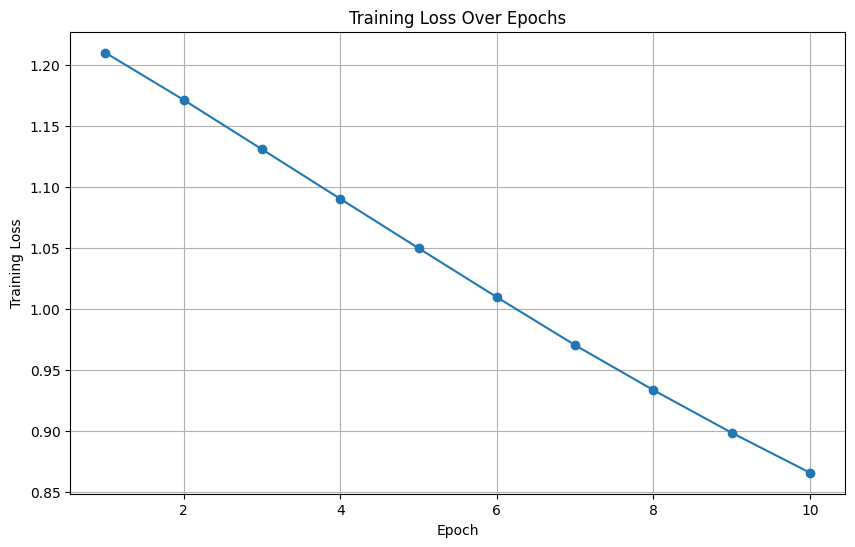

Initial loss: 1.2098
Final loss: 0.8660
Improvement: 28.4%


In [6]:
# Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")


## Save the Fine-Tuned Model

Save the LoRA adapter weights so we can use the fine-tuned model later.


In [7]:
# Save the LoRA adapter and tokenizer
# Generate a timestamped path for the model
model_path = timestamped_path("outputs/models", "embeddinggemma_lora", "").parent

# Save adapter (only LoRA weights, not the full model)
model.save_pretrained(str(model_path))
tokenizer.save_pretrained(str(model_path))

print(f"Model saved to: {model_path}")
print("\nTo load this model later:")
print(f"  from peft import PeftModel")
print(f"  base_model = AutoModel.from_pretrained('google/embeddinggemma-300m')")
print(f"  model = PeftModel.from_pretrained(base_model, '{model_path}')")


Model saved to: outputs/models

To load this model later:
  from peft import PeftModel
  base_model = AutoModel.from_pretrained('google/embeddinggemma-300m')
  model = PeftModel.from_pretrained(base_model, 'outputs/models')
